In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="artmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
artFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
artFOSID = artFOSID.filter(artFOSID["Domain"]=="Art").collect()

In [8]:
len(artFOSID)

118

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(artFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+------+
|   FOS_ID|Domain|
+---------+------+
|107038049|   Art|
| 49774154|   Art|
+---------+------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

2327755

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [21]:
(sample1,sample2) = papers_filtered1.randomSplit([0.5,0.5])

In [22]:
sample1.count()

1057039

In [21]:
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [23]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             0|
|             0|
|             1|
|             0|
+--------------+
only showing top 4 rows



In [25]:
sample1_pd = sample1.toPandas()

In [26]:
import numpy as np

In [27]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [29]:
from sklearn import metrics

In [30]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 0.6882745102120168)
('Mean Squared Error of EstimatedCount:', 2408.0718658441174)
('Root Mean Squared of with EstimatedCount:', 49.07210883836273)


In [31]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [32]:
sample1_pd.shape

(1057039, 12)

In [33]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [34]:
from sklearn.model_selection import KFold

In [35]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 1.0410636648288996)
('Mean Squared Error:', 135.24136366012186)
('Root Mean Squared Error:', 11.629332038432898)
('Mean Absolute Error:', 0.8094063417597724)
('Mean Squared Error:', 453.200094072531)
('Root Mean Squared Error:', 21.288496754645006)
('Mean Absolute Error:', 0.7819894012651143)
('Mean Squared Error:', 82.8919285876335)
('Root Mean Squared Error:', 9.104500457885292)
('Mean Absolute Error:', 1.2283431625310837)
('Mean Squared Error:', 390.72423140777727)
('Root Mean Squared Error:', 19.76674559475528)
('Mean Absolute Error:', 0.4059455548165479)
('Mean Squared Error:', 44.396024572572756)
('Root Mean Squared Error:', 6.663034186657964)


In [38]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 13.690421806475289)


In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
featureslist=sample1_pd.columns

In [41]:
importances = regressor.feature_importances_

In [42]:
import pandas as pd

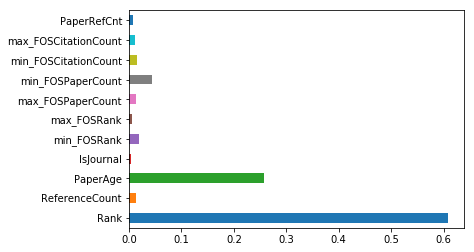

In [43]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model

In [44]:
import xgboost as xgb

In [45]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [46]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 211408,  211409,  211410, ..., 1057036, 1057037, 1057038]), 'TEST:', array([     0,      1,      2, ..., 211405, 211406, 211407]))
('Mean Absolute Error of XGBoost Kfold:', 1.1173260449078353)
('Mean Squared Error of XGBoost Kfold:', 145.57162035747595)
('Root Mean Squared Error of XGBoost Kfold:', 12.065306475903377)
('TRAIN:', array([      0,       1,       2, ..., 1057036, 1057037, 1057038]), 'TEST:', array([211408, 211409, 211410, ..., 422813, 422814, 422815]))
('Mean Absolute Error of XGBoost Kfold:', 0.8419962902020158)
('Mean Squared Error of XGBoost Kfold:', 396.67991187993766)
('Root Mean Squared Error of XGBoost Kfold:', 19.916824844335444)
('TRAIN:', array([      0,       1,       2, ..., 1057036, 1057037, 1057038]), 'TEST:', array([422816, 422817, 422818, ..., 634221, 634222, 634223]))
('Mean Absolute Error of XGBoost Kfold:', 0.8277363717718962)
('Mean Squared Error of XGBoost Kfold:', 79.2162295161757)
('Root Mean Squared Error of XGBoost Kfold:', 8.900

In [47]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 15.218038162497825)


In [48]:
importances = regressor.feature_importances_

In [49]:
import pandas as pd

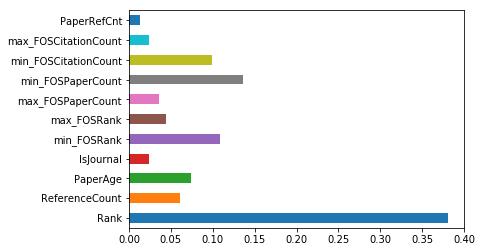

In [50]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [51]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.38046
Feature: 1, Score: 0.06091
Feature: 2, Score: 0.07448
Feature: 3, Score: 0.02449
Feature: 4, Score: 0.10880
Feature: 5, Score: 0.04408
Feature: 6, Score: 0.03597
Feature: 7, Score: 0.13561
Feature: 8, Score: 0.09869
Feature: 9, Score: 0.02356
Feature: 10, Score: 0.01296


In [56]:
papers_filtered.filter("IsJournal == 0").show(30)

+---------+---------+-----+---------+------+-----+--------------+-----+--------------+--------+---------+-----------+-----------+-----------------+-----------------+--------------------+--------------------+-----------+------+
|   FOS_ID|  PaperID| Rank|PaperYear|Volume|Issue|ReferenceCount|label|EstimatedCount|PaperAge|IsJournal|min_FOSRank|max_FOSRank|max_FOSPaperCount|min_FOSPaperCount|min_FOSCitationCount|max_FOSCitationCount|PaperRefCnt|Domain|
+---------+---------+-----+---------+------+-----+--------------+-----+--------------+--------+---------+-----------+-----------+-----------------+-----------------+--------------------+--------------------+-----------+------+
|124952713|  8471897|24332|     2010|    18|   18|             0|    0|             0|      10|        0|       9445|      25000|          4792512|             1610|                1757|             2692145|          0|   Art|
|124952713| 15744352|23844|     2011|    91|    1|             0|    0|             0|      